In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Load .mat data
data = scipy.io.loadmat(r'C:\Users\18216\Desktop\UC_train_test_case300.mat')

X_train = torch.tensor(data['X_train'], dtype=torch.float32)  # shape: [N, N_d, 24]
Y_train = torch.tensor(data['Y_train'], dtype=torch.float32)  # shape: [N, N_g, 24]
X_test = torch.tensor(data['X_test'], dtype=torch.float32)
Y_test = torch.tensor(data['Y_test'], dtype=torch.float32)
        
def calculate_violation_rate(X, Y, tolerance=8e-3):
    """
    Calculate power balance violation rate for raw UC data.
    
    Args:
        X: Demand data [num_buses, num_hours, num_days]
        Y: Generation data [num_gens, num_hours, num_days]
        tolerance: Allowed imbalance threshold (MW)
    
    Returns:
        violation_rate: Percentage of timesteps with imbalance > tolerance
    """
    total_demand = X.sum(axis=0)  # Sum across buses [hours, days]
    total_generation = Y.sum(axis=0)  # Sum across gens [hours, days]
    imbalance = np.abs(total_generation - total_demand)
    
    violations = (imbalance > tolerance).sum()
    total_timesteps = X.shape[1] * X.shape[2]
    
    return violations / total_timesteps * 100  # Percentage

violation_rate = calculate_violation_rate(X_train, Y_train)
print(f"Violation rate: {violation_rate:.2f}%")


Violation rate: 0.00%


In [82]:
print("The X_train shape:", X_train.shape)

def remove_zero_demand_buses(X_reshaped):
    """
    Args:
        X_reshaped: Demand data shaped [num_buses, num_samples] (9×19200 or 9×4800)
    Returns:
        X_filtered: Demand data with zero-demand buses removed
        kept_bus_indices: Indices of buses with non-zero demand
    """
    # Buses that have ANY NON-zero demand will not be removed
    non_zero_mask = (X_reshaped != 0).any(axis=1)
    kept_bus_indices = torch.where(non_zero_mask)[0]
    
    # Filter the data
    X_filtered = X_reshaped[non_zero_mask, :]
    
    return X_filtered

# Reshape and filter training data
X_train_reshaped = X_train.reshape(X_train.size(0), -1)  
X_train_filtered = remove_zero_demand_buses(X_train_reshaped)

# Reshape and filter test data (using same bus indices)
X_test_reshaped = X_test.reshape(X_test.size(0), -1)  
X_test_filtered = remove_zero_demand_buses(X_test_reshaped)

print(f"Filtered shape: {X_train_filtered.shape}") 
print("The first few rows of X_train_filtered:", X_train_filtered[:])
print("The first few rows of X_test_filtered:", X_test_filtered[:])

The X_train shape: torch.Size([300, 24, 800])
Filtered shape: torch.Size([199, 19200])
The first few rows of X_train_filtered: tensor([[80.9746, 70.8025, 67.6674,  ..., 77.7344, 88.6880, 89.9811],
        [41.8560, 42.3743, 45.5435,  ..., 56.2642, 53.8099, 56.2772],
        [17.6554, 15.7936, 15.7489,  ..., 19.6369, 17.8136, 20.3107],
        ...,
        [ 0.7614,  0.8935,  0.7885,  ...,  0.9792,  0.9748,  0.9134],
        [ 3.2383,  3.2281,  3.4464,  ...,  3.3090,  3.3374,  3.2573],
        [ 1.0463,  1.0507,  1.0056,  ...,  1.1557,  1.0624,  1.0013]])
The first few rows of X_test_filtered: tensor([[73.2134, 78.5854, 73.1251,  ..., 86.9432, 78.2952, 78.9419],
        [42.4413, 44.1527, 50.2502,  ..., 51.7694, 51.2210, 47.7908],
        [15.2741, 15.4150, 15.6246,  ..., 17.2834, 19.4529, 20.2907],
        ...,
        [ 0.8622,  0.8969,  0.8940,  ...,  0.8704,  0.9417,  0.9492],
        [ 3.3043,  3.3947,  2.9638,  ...,  3.2983,  3.7654,  3.8724],
        [ 0.9867,  0.9804,  1.0319,  

In [83]:
# Reshape the filtered X_train and X_test
N_demand = X_train_filtered.shape[0]
X_train = X_train_filtered.reshape(N_demand, 24, 800)
X_test = X_test_filtered.reshape(N_demand, 24, 200)
print("The shape of X_test:", X_test.shape)

The shape of X_test: torch.Size([199, 24, 200])


In [84]:
# Data normalization
def normalize(X):
    """
    Args:
        X: Input tensor [num_demands, num_hours, num_days]
    Returns:
        X_norm: Normalized tensor [num_demands, num_hours, num_days]
        means: Per-bus means [num_demands]
        stds: Per-bus stds [num_demands]
    """
    # Compute stats across ALL hours and days
    means = X.mean(dim=(1, 2))  
    stds = X.std(dim=(1, 2))    
    stds[stds < 1e-6] = 1e-6    # Avoid division by zero
    
    # Normalize
    X_norm = (X - means.view(-1, 1, 1)) / stds.view(-1, 1, 1)
    return X_norm, means, stds

# Train set normalization
X_train_norm, X_train_means, X_train_stds = normalize(X_train)
X_test_norm, X_test_means, X_test_stds = normalize(X_test)

print("The X_test_norm shape:", X_test_norm.shape)
first_two_days = X_train_norm[:, :, :2]  

# Print first day's data for all buses
print("First day generation:")
print(first_two_days[:, :, 0])  
print("Total X_train and X_test means:", X_train_means.sum(), X_test_means.sum())
imbalance_tolerance = 0.008 * ((X_train_means.sum() + X_test_means.sum())/2)
print("The imbalance tolerance for case300 is:", imbalance_tolerance)

The X_test_norm shape: torch.Size([199, 24, 200])
First day generation:
tensor([[-0.7714, -0.4832, -0.6217,  ...,  0.9365,  0.7873,  0.0344],
        [-1.9181, -1.6779, -1.7934,  ..., -0.4947, -0.6190, -1.2465],
        [-0.9216, -0.6390, -0.7749,  ...,  0.7529,  0.6066, -0.1315],
        ...,
        [-1.9031, -1.6631, -1.7785,  ..., -0.4809, -0.6052, -1.2321],
        [-1.1107, -0.8384, -0.9693,  ...,  0.5033,  0.3623, -0.3492],
        [-0.9447, -0.6636, -0.7987,  ...,  0.7209,  0.5754, -0.1588]])
Total X_train and X_test means: tensor(23521.7539) tensor(23526.8125)
The imbalance tolerance for case300 is: tensor(188.1943)


In [85]:
# Reshape datasets to [800*24,num_demand] for training and [200*24,num_demand] for test, each row stands for a time step
X_train_norm = X_train_norm.reshape(-1, X_train.size(0))
X_test_norm = X_test_norm.reshape(-1, X_test.size(0))

print("Now the X_train_norm shape is:", X_train_norm.shape)
print("The input size for NN is:", X_train_norm.size(1))

Now the X_train_norm shape is: torch.Size([19200, 199])
The input size for NN is: 199


In [86]:
# Apply min-max scale for Y_train and Y_test
N_gen = Y_train.size(0)
P_max = torch.tensor([100,100,100,100,100,475,255,390,168,217,2030,340,100,100,381,796,184,317,203,472,316,100,305,100,328,184,300,1300,1300,575,2073,524,372,200,550,350,403,445,400,700,350,650,675,270,184,567,723,1310,334,472,430,285,510,600,137,2399,145,265,500,500,216,1392,800,653,100,100,100,150,108], dtype=torch.float32)  
P_min = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.float32)      

# note the use of permute().reshape()
Y_train_flat = Y_train.permute(1, 2, 0).reshape(-1, N_gen)  # [hours*days, gens]
Y_test_flat = Y_test.permute(1, 2, 0).reshape(-1, N_gen)     # [hours*days, gens]

# Proper min-max scaling
Y_train_scaled = (Y_train_flat - P_min) / (P_max - P_min)
Y_test_scaled = (Y_test_flat - P_min) / (P_max - P_min)

# Verify
print("Y_train_scaled range (min):", Y_train_scaled.min(dim=0).values)
print("Y_train_scaled range (max):", Y_train_scaled.max(dim=0).values)
# Should output ~[0, 1] for each generator
print("Y_test_scaled range (min):", Y_test_scaled.min(dim=0).values)

print("Y_train_scaled shape:", Y_train_scaled.shape)
print("Y_test_scaled shape:", Y_test_scaled.shape)

Y_train_scaled range (min): tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6227, 0.4795, 0.5866, 0.3193,
        0.4253, 0.7741, 0.5568, 0.0000, 0.0000, 0.5818, 0.6897, 0.3601, 0.5400,
        0.4002, 0.6217, 0.5392, 0.0000, 0.5302, 0.0000, 0.5483, 0.3601, 0.5259,
        0.7419, 0.7384, 0.6516, 0.7749, 0.6383, 0.5768, 0.3944, 0.6454, 0.5634,
        0.5931, 0.6116, 0.5916, 0.6761, 0.5634, 0.6675, 0.6725, 0.4967, 0.3601,
        0.6497, 0.6797, 0.7377, 0.5526, 0.6217, 0.6054, 0.5120, 0.6341, 0.6573,
        0.2130, 0.0000, 0.2448, 0.4911, 0.6310, 0.6310, 0.4236, 0.7475, 0.6902,
        0.6680, 0.0000, 0.0000, 0.0000, 0.2629, 0.0584])
Y_train_scaled range (max): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9099, 0.7006, 0.8571, 0.4665,
        0.6214, 1.0000, 0.8136, 1.0000, 1.0000, 0.8501, 1.0000, 0.5262, 0.7890,
        0.5848, 0.9084, 0.7878, 1.0000, 0.7747, 1.0000, 0.8012, 0.5262, 0.7684,
        1.0000, 1.0000, 0.9521, 1.0000, 0.9326, 0.8428, 0.5763, 0.9430, 0.8233,
       

In [87]:
def power_balance_penalty(pred_gen, demand, tolerance):
    """
    New penalty function:
    - Returns 0 if imbalance ≤ tolerance (no penalty)
    - Returns (imbalance - tolerance) if imbalance > tolerance (linear penalty)
    """
    imbalance = torch.abs(demand.sum(dim=1) - pred_gen.sum(dim=1)).abs()  # [batch_size]
    violation = torch.clamp_min(imbalance - tolerance, 0)  # ReLU-like
    return violation.mean()  # Mean across batch

In [88]:
def project_to_feasible(pred_normalized, demand, P_min, P_max, X_means, X_stds, imbalance_tolerance):
    """
    Forces power balance while respecting generator limits.
    Only projects values that violate the power imbalance tolerance.
    """
    pred_MW = pred_normalized * (P_max - P_min) + P_min
    demand_MW = demand * X_stds + X_means
    total_demand = demand_MW.sum(dim=1, keepdim=True)
    
    # Case 1: If generation is zero (edge case)
    gen_sum = pred_MW.sum(dim=1, keepdim=True)
    pred_MW[gen_sum.squeeze() < 1e-6] = total_demand[gen_sum.squeeze() < 1e-6] / pred_MW.shape[1]
    
    # Calculate current imbalance
    current_imbalance = torch.abs(pred_MW.sum(dim=1, keepdim=True) - total_demand)
    
    # Only project samples where imbalance exceeds tolerance
    needs_projection = current_imbalance > imbalance_tolerance
    
    # Initialize feasible_gen with original values
    feasible_gen = pred_MW.clone()
    
    # Apply projection only where needed
    feasible_gen[needs_projection.squeeze()] = (
        pred_MW[needs_projection.squeeze()] * 
        (total_demand[needs_projection.squeeze()] / 
         (pred_MW[needs_projection.squeeze()].sum(dim=1, keepdim=True) + 1e-6))
    )
    
    return feasible_gen

In [89]:
#Hyperparameters
input_size = X_train_norm.size(1)
output_size = Y_train_scaled.size(1)
hidden_size_1 = 512   
hidden_size_2 = 256
hidden_size_3 = 128
num_epochs = 1000        
batch_size = 256      
learning_rate = 3e-2   

a = 1.0  # MSE weight 
b = 0.01   
# tolerance = 1

class Load2GenNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(Load2GenNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.BatchNorm1d(hidden_size_3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_3, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss, optimizer
model = Load2GenNN(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,           # Start with higher LR than Adam (typical range: 0.01-0.1)
    momentum=0.9,      # Critical for escaping local minima (range: 0.8-0.99)
    weight_decay=1e-4, # Stronger L2 regularization helps with momentum
    nesterov=True      # Nesterov accelerated gradient (recommended)
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

train_dataset = TensorDataset(X_train_norm, Y_train_scaled)
test_dataset = TensorDataset(X_test_norm, Y_test_scaled)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [90]:
train_losses = []
test_losses = []
train_penalties = []  
test_penalties = [] 
train_mses = []
test_mses = []
raw_feasibility_rates = []
projected_feasibility_rates = []

for epoch in range(num_epochs):
    # ==================== TRAINING ====================
    model.train()
    epoch_train_loss = 0.0
    epoch_train_penalty = 0.0
    epoch_train_mse = 0.0
       
    for xb, yb in train_loader:
        # Forward pass
     
        pred = model(xb)
        mse_loss = criterion(pred, yb)
        real_pred = pred * (P_max - P_min) + P_min
        real_xb = xb * X_train_stds + X_train_means
        
        balance_penalty = power_balance_penalty(real_pred, real_xb, imbalance_tolerance)
        loss = a * mse_loss + b * balance_penalty
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  
        optimizer.step()
        
        # Track losses
        epoch_train_loss += loss.item()
        epoch_train_mse += mse_loss.item()
        epoch_train_penalty += balance_penalty.item()
    
    # Store training metrics
    train_losses.append(epoch_train_loss / len(train_loader))
    train_penalties.append(epoch_train_penalty / len(train_loader))
    train_mses.append(epoch_train_mse/len(train_loader))

    # ==================== VALIDATION ====================
    model.eval()
    epoch_test_loss = 0.0
    epoch_test_mse = 0.0
    epoch_test_penalty = 0.0
    epoch_raw_feasible = 0.0
    epoch_proj_feasible = 0.0
    all_preds = []
    all_imbalances = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            
            # Forward pass
            pred = model(xb)  

            # all_preds.append(pred.cpu())
            
            mse_loss = criterion(pred, yb)
            real_pred = pred * (P_max - P_min) + P_min
            real_xb = xb * X_test_stds + X_test_means
            
            # Calculate metrics
            balance_penalty = power_balance_penalty(real_pred, real_xb, imbalance_tolerance)
            loss = a * mse_loss + b * balance_penalty
            
            epoch_test_loss += loss.item()
            epoch_test_mse += mse_loss.item()
            epoch_test_penalty += balance_penalty.item()
            
            # Feasibility checks
            raw_imbalance = torch.abs(real_xb.sum(dim=1) - real_pred.sum(dim=1))
            epoch_raw_feasible += (raw_imbalance <= imbalance_tolerance).float().mean().item()
            
            projected_pred = project_to_feasible(pred, xb, P_min, P_max, X_test_means, X_test_stds, imbalance_tolerance)
            all_preds.append(projected_pred.cpu()) # Store all projected solutions
            
            proj_imbalance = torch.abs(real_xb.sum(dim=1) - projected_pred.sum(dim=1))
            epoch_proj_feasible += (proj_imbalance <= imbalance_tolerance).float().mean().item()
            
            all_imbalances.append(proj_imbalance.cpu())
    
    # Store validation metrics
    test_loss = epoch_test_loss / len(test_loader)
    test_mse = epoch_test_mse / len(test_loader)
    test_penalty = epoch_test_penalty / len(test_loader)
    raw_feasibility = 100 * epoch_raw_feasible / len(test_loader)
    projected_feasibility = 100 * epoch_proj_feasible / len(test_loader)
    
    test_losses.append(test_loss)
    test_mses.append(test_mse)
    test_penalties.append(test_penalty)
    raw_feasibility_rates.append(raw_feasibility)
    projected_feasibility_rates.append(projected_feasibility)
    
    if epoch_test_mse > 0.042:
        a = 4.0
        b = 0.01
    if epoch_test_mse < 0.035:
        a = 1.0
        b = 0.01
       
    # Print every N epochs
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        max_imbalance = torch.cat(all_imbalances).max().item()
        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_loss:.4f}")
        print(f"MSE loss: {test_mse:.4f} | Penalty Loss: {test_penalty:.4f}")
        print(f"Raw Feasibility: {raw_feasibility:.2f}% | Projected: {projected_feasibility:.2f}%")
        #print(f"Max Projected Imbalance: {max_imbalance:.6f} MW")


Epoch 1:
Train Loss: 11.5541 | Test Loss: 2.8903
MSE loss: 0.0702 | Penalty Loss: 282.0148
Raw Feasibility: 23.88% | Projected: 100.00%

Epoch 11:
Train Loss: 0.9919 | Test Loss: 0.2670
MSE loss: 0.0647 | Penalty Loss: 0.8284
Raw Feasibility: 98.34% | Projected: 100.00%

Epoch 21:
Train Loss: 0.7041 | Test Loss: 0.2672
MSE loss: 0.0616 | Penalty Loss: 2.0741
Raw Feasibility: 96.29% | Projected: 100.00%

Epoch 31:
Train Loss: 0.6394 | Test Loss: 0.2416
MSE loss: 0.0589 | Penalty Loss: 0.5846
Raw Feasibility: 98.99% | Projected: 100.00%

Epoch 41:
Train Loss: 0.7133 | Test Loss: 0.2349
MSE loss: 0.0564 | Penalty Loss: 0.9435
Raw Feasibility: 96.05% | Projected: 100.00%

Epoch 51:
Train Loss: 0.5532 | Test Loss: 0.2184
MSE loss: 0.0535 | Penalty Loss: 0.4541
Raw Feasibility: 98.92% | Projected: 100.00%

Epoch 61:
Train Loss: 0.5398 | Test Loss: 0.2078
MSE loss: 0.0517 | Penalty Loss: 0.0971
Raw Feasibility: 99.63% | Projected: 100.00%

Epoch 71:
Train Loss: 0.4948 | Test Loss: 0.2183
MSE


Epoch 611:
Train Loss: 0.1903 | Test Loss: 0.1385
MSE loss: 0.0345 | Penalty Loss: 0.0505
Raw Feasibility: 99.75% | Projected: 100.00%

Epoch 621:
Train Loss: 0.1800 | Test Loss: 0.1369
MSE loss: 0.0342 | Penalty Loss: 0.0198
Raw Feasibility: 99.90% | Projected: 100.00%

Epoch 631:
Train Loss: 0.1911 | Test Loss: 0.1376
MSE loss: 0.0344 | Penalty Loss: 0.0017
Raw Feasibility: 99.98% | Projected: 100.00%

Epoch 641:
Train Loss: 0.1768 | Test Loss: 0.1369
MSE loss: 0.0342 | Penalty Loss: 0.0002
Raw Feasibility: 99.98% | Projected: 100.00%

Epoch 651:
Train Loss: 0.2024 | Test Loss: 0.1364
MSE loss: 0.0341 | Penalty Loss: 0.0187
Raw Feasibility: 99.92% | Projected: 100.00%

Epoch 661:
Train Loss: 0.1901 | Test Loss: 0.1365
MSE loss: 0.0341 | Penalty Loss: 0.0000
Raw Feasibility: 100.00% | Projected: 100.00%

Epoch 671:
Train Loss: 0.1923 | Test Loss: 0.1354
MSE loss: 0.0336 | Penalty Loss: 0.0830
Raw Feasibility: 99.65% | Projected: 100.00%

Epoch 681:
Train Loss: 0.1834 | Test Loss: 0.1


Epoch 1211:
Train Loss: 0.1712 | Test Loss: 0.1356
MSE loss: 0.0339 | Penalty Loss: 0.0000
Raw Feasibility: 100.00% | Projected: 100.00%

Epoch 1221:
Train Loss: 0.1714 | Test Loss: 0.1417
MSE loss: 0.0336 | Penalty Loss: 0.7337
Raw Feasibility: 96.20% | Projected: 100.00%

Epoch 1231:
Train Loss: 0.1769 | Test Loss: 0.1348
MSE loss: 0.0337 | Penalty Loss: 0.0000
Raw Feasibility: 100.00% | Projected: 100.00%

Epoch 1241:
Train Loss: 0.1667 | Test Loss: 0.1352
MSE loss: 0.0338 | Penalty Loss: 0.0048
Raw Feasibility: 99.94% | Projected: 100.00%

Epoch 1251:
Train Loss: 0.1650 | Test Loss: 0.1354
MSE loss: 0.0338 | Penalty Loss: 0.0050
Raw Feasibility: 99.98% | Projected: 100.00%

Epoch 1261:
Train Loss: 0.1643 | Test Loss: 0.1354
MSE loss: 0.0338 | Penalty Loss: 0.0000
Raw Feasibility: 100.00% | Projected: 100.00%

Epoch 1271:
Train Loss: 0.1735 | Test Loss: 0.1363
MSE loss: 0.0338 | Penalty Loss: 0.1199
Raw Feasibility: 99.47% | Projected: 100.00%

Epoch 1281:
Train Loss: 0.1629 | Test


Epoch 1811:
Train Loss: 0.1641 | Test Loss: 0.1353
MSE loss: 0.0338 | Penalty Loss: 0.0012
Raw Feasibility: 99.98% | Projected: 100.00%

Epoch 1821:
Train Loss: 0.1670 | Test Loss: 0.1348
MSE loss: 0.0337 | Penalty Loss: 0.0000
Raw Feasibility: 100.00% | Projected: 100.00%

Epoch 1831:
Train Loss: 0.1706 | Test Loss: 0.1357
MSE loss: 0.0339 | Penalty Loss: 0.0192
Raw Feasibility: 99.86% | Projected: 100.00%

Epoch 1841:
Train Loss: 0.1771 | Test Loss: 0.1355
MSE loss: 0.0338 | Penalty Loss: 0.0077
Raw Feasibility: 99.94% | Projected: 100.00%

Epoch 1851:
Train Loss: 0.1609 | Test Loss: 0.1357
MSE loss: 0.0339 | Penalty Loss: 0.0037
Raw Feasibility: 99.98% | Projected: 100.00%

Epoch 1861:
Train Loss: 0.1726 | Test Loss: 0.1356
MSE loss: 0.0338 | Penalty Loss: 0.0348
Raw Feasibility: 99.86% | Projected: 100.00%

Epoch 1871:
Train Loss: 0.1685 | Test Loss: 0.1357
MSE loss: 0.0339 | Penalty Loss: 0.0003
Raw Feasibility: 99.98% | Projected: 100.00%

Epoch 1881:
Train Loss: 0.1704 | Test L


Epoch 2411:
Train Loss: 0.1761 | Test Loss: 0.1351
MSE loss: 0.0337 | Penalty Loss: 0.0240
Raw Feasibility: 99.86% | Projected: 100.00%

Epoch 2421:
Train Loss: 0.1654 | Test Loss: 0.1374
MSE loss: 0.0338 | Penalty Loss: 0.2013
Raw Feasibility: 99.31% | Projected: 100.00%

Epoch 2431:
Train Loss: 0.1774 | Test Loss: 0.1369
MSE loss: 0.0339 | Penalty Loss: 0.1403
Raw Feasibility: 99.44% | Projected: 100.00%

Epoch 2441:
Train Loss: 0.1587 | Test Loss: 0.1358
MSE loss: 0.0339 | Penalty Loss: 0.0021
Raw Feasibility: 99.98% | Projected: 100.00%

Epoch 2451:
Train Loss: 0.1629 | Test Loss: 0.1353
MSE loss: 0.0338 | Penalty Loss: 0.0190
Raw Feasibility: 99.90% | Projected: 100.00%

Epoch 2461:
Train Loss: 0.1713 | Test Loss: 0.1351
MSE loss: 0.0338 | Penalty Loss: 0.0000
Raw Feasibility: 100.00% | Projected: 100.00%

Epoch 2471:
Train Loss: 0.1701 | Test Loss: 0.1356
MSE loss: 0.0339 | Penalty Loss: 0.0000
Raw Feasibility: 100.00% | Projected: 100.00%

Epoch 2481:
Train Loss: 0.1583 | Test 

In [91]:
def count_zero_predictions(all_preds):
    """
    Counts zero predictions (values < 1e-6) across all_preds.
    
    Args:
        all_preds: List of prediction tensors (normalized [0,1])
        
    Returns:
        int: Total count of zero values
    """
    return (torch.cat(all_preds, dim=0) < 1e-6).sum().item()

# Usage
zero_count = count_zero_predictions(all_preds)
print(f"Total zeros in predictions: {zero_count}")

Total zeros in predictions: 0


In [93]:
def analyze_hourly_ramp_violations(all_preds, P_min, P_max, min_ramp_limits_MW_per_hour, max_ramp_limits_MW_per_hour):
    """
    Analyze hourly ramp violations (1-hour time steps).
    
    Args:
        all_preds: List of normalized prediction tensors [batch_size, num_gens] ∈ [0,1]
        P_min/P_max: Generator limits [num_gens] (MW)
        min/max_ramp_limits_MW_per_hour: Ramp limits [num_gens] (MW/hour)
    
    Returns:
        Dict with:
        - 'max_violation': Maximum violation magnitude (MW)
        - 'worst_generator': Index of most violating generator
        - 'violation_rate': % of intervals with violations
        - 'per_gen_stats': DataFrame with per-generator statistics
    """
    # Convert to MW and concatenate
    preds_MW = torch.cat(all_preds, dim=0)  # [num_hours, num_gens]
    
    # Calculate hourly ramps
    deltas = torch.diff(preds_MW, dim=0)  # [num_hours-1, num_gens] (MW change/hour)
    
    # Check violations (absolute delta > limit)
    violations_to_min = deltas.abs() > min_ramp_limits_MW_per_hour  # Boolean mask
    violations_to_max = deltas.abs() > max_ramp_limits_MW_per_hour
    violation_magnitudes = (deltas.abs() - max_ramp_limits_MW_per_hour).clamp_min(0)
    
    # Aggregate statistics
    max_violation = violation_magnitudes.max().item()
    worst_generator = violation_magnitudes.max(dim=1)[0].argmax().item()
    
    # Per-generator stats
    import pandas as pd
    per_gen_stats = pd.DataFrame({
        'Generator': [f'G{i+1}' for i in range(len(min_ramp_limits_MW_per_hour))],
        'MinRampLimit_MW/h': min_ramp_limits_MW_per_hour.cpu().numpy(),
        'MaxRampLimit_MW/h': max_ramp_limits_MW_per_hour.cpu().numpy(),
        'Violation_to_minCount': violations_to_min.sum(dim=0).cpu().numpy(),
        'Violation_to_maxCount': violations_to_max.sum(dim=0).cpu().numpy(),
        'MaxViolation_MW': violation_magnitudes.max(dim=0)[0].cpu().numpy(),
        'AvgViolation_MW': violation_magnitudes.mean(dim=0).cpu().numpy()
    })
    
    return {
        'max_violation': max_violation,
        'worst_generator': worst_generator,
        'max_violation_rate': 100 * violations_to_min.float().mean().item(),
        'min_violation_rate': 100 * violations_to_max.float().mean().item(),
        'per_gen_stats': per_gen_stats,
        'total_hours': preds_MW.shape[0] - 1
    }

# Usage Example
min_ramp_limits = torch.full((N_gen,), 90.0) 
max_ramp_limits = torch.full((N_gen,), 114.0)
stats = analyze_hourly_ramp_violations(all_preds, P_min, P_max, min_ramp_limits, max_ramp_limits)

print(f"""
=== Hourly Ramp Violation Report ===
Max violation: {stats['max_violation']:.2f} MW
Worst generator: G{stats['worst_generator']+1}
Global maximum violation rate: {stats['max_violation_rate']:.2f}%
Global minimum violation rate: {stats['min_violation_rate']:.2f}%
Total hours analyzed: {stats['total_hours']}
""")
# print("\nPer-generator statistics:")
# print(stats['per_gen_stats'].to_markdown(index=False))


=== Hourly Ramp Violation Report ===
Max violation: 836.05 MW
Worst generator: G4173
Global maximum violation rate: 2.19%
Global minimum violation rate: 1.86%
Total hours analyzed: 4799



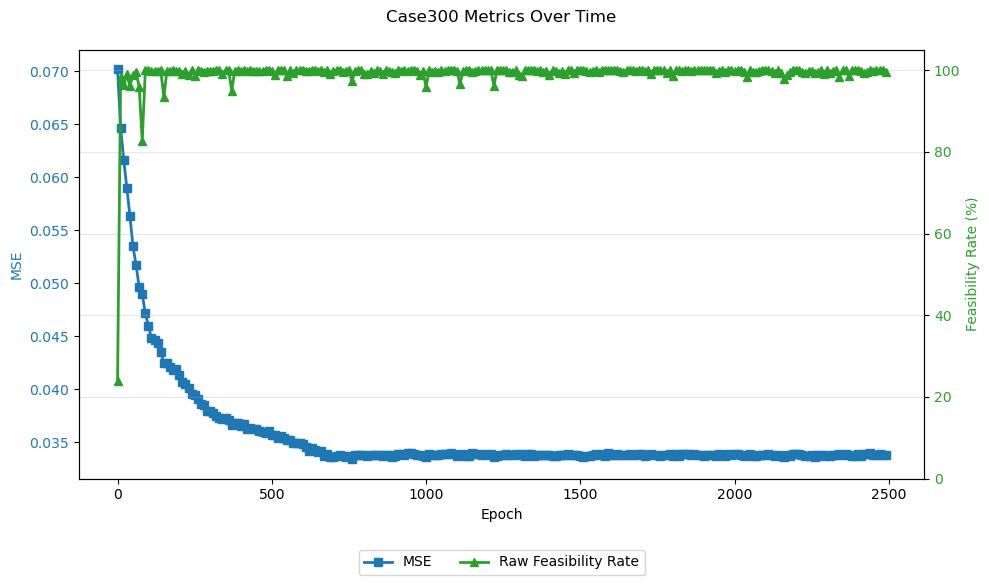

In [94]:
# Visualization of the validation
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these lists:
# test_losses = [...]         # List of loss values
# test_mses = [...]           # List of MSE values (100 values)
# raw_feasibility_rates = [...]  # List of feasibility rates (100 values, 0-100%)

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Sample every 10 epochs
sample_interval = 10
x_vals = np.arange(0, len(test_mses), sample_interval)
sampled_mses = test_mses[::sample_interval]
sampled_feas = raw_feasibility_rates[::sample_interval]

# Plot MSE (left y-axis, changed to blue)
color_mse = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE', color=color_mse)
line_mse, = ax1.plot(x_vals, sampled_mses, 's-', color=color_mse, label='MSE', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color_mse)

# Create secondary y-axis for Feasibility Rate
ax2 = ax1.twinx()
color_feas = 'tab:green'
ax2.set_ylabel('Feasibility Rate (%)', color=color_feas)
line_feas, = ax2.plot(x_vals, sampled_feas, '^-', color=color_feas, label='Raw Feasibility Rate', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color_feas)
ax2.set_ylim(0, 105)  # Ensure full range is visible

# Combine legends from both axes
lines = [line_mse, line_feas]
ax1.legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.title('Case300 Metrics Over Time', pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()